In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Define the observed distribution

In [2]:
###############################
# Define a covariance matrix
###############################

cov = {'wx': 1, 'xy': 3, 'wy': 2, 'ww': 9, 'xx': 9, 'yy': 9}

#############################
# Choose Lambda
#############################
lda = 5

## Generate valid parameters

Here we generate valid parameterizations.  Notable restrictions implied by the model
1. $\rho_W$ is lower bounded by the squared covariance of W, X
2. $\sigma_Y^2$ cannot go below zero

In [3]:
# Verify that the chosen covariance matrix is PD
cov_mat = np.array(
    [[cov['xx'], cov['xy'], cov['wx']],
     [cov['xy'], cov['yy'], cov['wy']],
     [cov['wx'], cov['wy'], cov['ww']]])

w, _ = np.linalg.eig(cov_mat)
assert np.all(w > 0) # Verify that covariance is PD
print(w)

[13.11309058  5.79808822  8.08882119]


In [4]:
corr_wx = cov['wx'] / np.sqrt(cov['xx'] * cov['ww'])
assert corr_wx < 1 and corr_wx > 0

# Generate a range of feasible rho_w
# The smallest rw corresponds to the largest rx, which is 1.
min_rw = corr_wx**2
rw = np.linspace(min_rw+0.001, 1, 1000)
#rw = np.linspace(0.06, 1, 1000)

# Generate all remaining values
rx = corr_wx**2 / rw

sx = cov['xx'] * (1 - rx)
sw = cov['ww'] * (1 - rw)

bw = np.sqrt(cov['ww'] * rw)
bx = np.sqrt(cov['xx'] * rx)
by = (1 / (bw * (1 - rx))) * (cov['wy'] - (cov['xy'] * cov['wx']) / cov['xx'])
a = (cov['xy'] - by * bx) / cov['xx']

sy = cov['yy'] - by**2 - (2*a*by*bx) - (a**2) * cov['xx']

In [5]:
print(f"$\\rho_W$ cannot go below {min_rw}")

$\rho_W$ cannot go below 0.012345679012345678


In [6]:
# Verify that all observed moments match
e_wx = bw * bx
assert np.all(np.isclose(e_wx, cov['wx']))

e_xy = by * bx + a * cov['xx']
assert np.all(np.isclose(e_xy, cov['xy']))

e_wy = bw * (by + a * bx)
assert np.all(np.isclose(e_wy, cov['wy']))

e_ww = bw**2 + sw
assert np.all(np.isclose(e_ww, cov['ww']))

e_xx = bx**2 + sx
assert np.all(np.isclose(e_xx, cov['xx']))

e_yy = (a**2)*cov['xx'] + (2*a*by*bx) + by**2 + sy
assert np.all(np.isclose(e_yy, cov['yy']))

Later, we will filter out all instances where `sy < 0`, which will remove some of these

## Compute solutions

We compute the anchor regression solution (which relies upon the unidentified variables) for each parameterization, and can then compare this to the solution when a single proxy is used, which is fixed (because it uses only the observed distribution over X, Y, W)

In [7]:
# Anchor Regression Solution
g_a = ((a * bx**2 + bx * by)*(1 + lda) + a * sx) \
    / ((bx**2 * (1 + lda) + sx))

# Proxy Anchor Regression solution
g_w = (cov['xy'] * cov['ww'] + lda * cov['wy']) \
    / (cov['xx'] * cov['ww'] + lda * cov['wx']) 

We can then compute the expected loss, under the worst-case shift

In [8]:
def get_loss(g, shift, noise=True):
    loss = (((a - g) * bx + by)**2)*(shift) + ((a - g)**2) * sx
    if noise:
        loss = loss + sy
    return loss

loss_g_a = get_loss(g_a, 1 + lda, noise=True)
loss_g_w = get_loss(g_w, 1 + lda, noise=True)

In [9]:
results = np.array([
    # Parameters
    rw, rx, sw, sx, sy, 
    bw, bx, by, a, 
    # AR solution
    g_a, 
    # Loss under different models
    loss_g_a, loss_g_w, 
    loss_g_w - loss_g_a]).T

results_df = pd.DataFrame(results, columns=[
    'rho_W', 'rho_X', 'sig_W', 'sig_X', 'sig_Y', 
    'b_W', 'b_X', 'b_Y', 'a', 
    'g_a', 
    'loss_g_a', 'loss_g_w', 
    'diff_loss_w_a'])

# Filter for parameterizations that are valid
results_df = results_df.query('sig_Y > 0 & rho_X < 1')

In [10]:
print(f"After filtering out negative values of sigma_Y, the minimum $\\rho_W$ is {results_df['rho_W'].min()}")

After filtering out negative values of sigma_Y, the minimum $\rho_W$ is 0.05186371556741927


## Plot results

In [11]:
def plot_vars(var_list, df, id_vars=['rho_W']):
    
    long_df = pd.melt(df, id_vars=id_vars)
    long_df.rename(columns = {'variable': 'Parameter'}, inplace=True)
    
    f, ax = plt.subplots(figsize=(6.5, 6.5))
    sns.lineplot(x='rho_W', y='value', hue='Parameter', 
                    data=long_df.query('Parameter in @var_list'),
                    ax=ax)
    ax.set_xlabel('$\\rho_W$')
    
    return f, ax

### Figure 10(a)

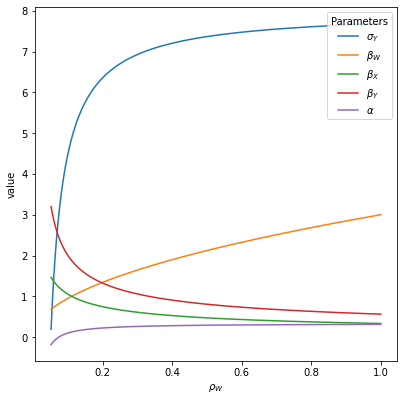

In [13]:
var_list = ['b_W', 'b_X', 'b_Y', 'a', 'sig_Y']
f, ax = plot_vars(var_list, results_df)

plt.legend(title='Parameters', loc='upper right', labels=['$\\sigma_Y$', '$\\beta_W$', '$\\beta_X$', '$\\beta_Y$', '$\\alpha$'])
#plt.savefig("figs/id_example_parameters.pdf")
plt.show()

### Figure 10(b)

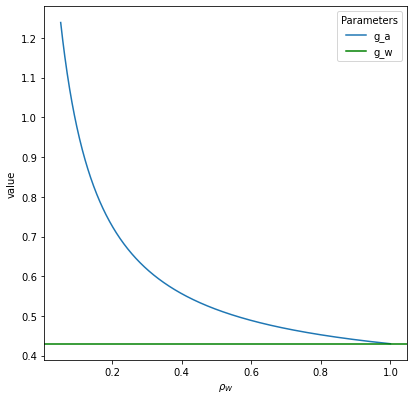

In [14]:
var_list = ['g_a']
f, ax = plot_vars(var_list, results_df)

# Plot the value of gamma when W is used 
ax.axhline(y=g_w, xmin=0, xmax=1, label='g_w', color='green')

plt.legend(title='Parameters', loc='upper right')
           #colors=['green', 'blue'])
#plt.savefig("figs/id_example_gamma.pdf")
plt.show()